In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [5]:
if(os.path.split(os.getcwd())[1] == "semi-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = True

Current Working Directory: progettoVIPM


In [6]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [10]:
from torch.utils.data import DataLoader, ConcatDataset, random_split


trainL = ImageDataset(datasets.TRAINING_LABELED_80, 224, cuda=True)

trainM = ImageDataset(datasets.TRAINING_MIXED_LABELSPREAD, 224, True)
val = ImageDataset(datasets.VALIDATION_LABELED_20, 224, cuda=True)
test = ImageDataset(datasets.TEST, 224, cuda=True)

trainL = DataLoader(trainL, batch_size=128, shuffle=True)

trainM = DataLoader(trainM, batch_size=128, shuffle=True)
valL = DataLoader(val, batch_size=128, shuffle=False)
test = DataLoader(test, batch_size=128, shuffle=False)

In [16]:
model = models.resnet50()
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("C:\\Users\\marco\\Desktop\\Uni\\Magistrale\\VIPM\\Progetto\\resnet50model.pth")['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
num_classes = 251
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

In [20]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
best_model_path = 'semi-supervised/models/best_FineTuned_ResNet50.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainM:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainM)}')
        labels = [int(label) for label in labels]
        
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainM)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainM))
    print('Validation:')
    model.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = model(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 121
Batch 20 di 121
Batch 30 di 121
Batch 40 di 121
Batch 50 di 121
Batch 60 di 121
Batch 70 di 121
Batch 80 di 121
Batch 90 di 121
Batch 100 di 121
Batch 110 di 121
Batch 120 di 121
Training Loss: 5.147429533241209, Accuracy: 4.316125252262222%
Validation:
Validation Loss: 4.724374890327454, Accuracy: 9.46215139442231%
Best model saved with validation loss: 4.724374890327454
Epoch: 2
Training:
Batch 10 di 121
Batch 20 di 121
Batch 30 di 121
Batch 40 di 121
Batch 50 di 121
Batch 60 di 121
Batch 70 di 121
Batch 80 di 121
Batch 90 di 121
Batch 100 di 121
Batch 110 di 121
Batch 120 di 121
Training Loss: 4.36117534401003, Accuracy: 13.072065620727818%
Validation:
Validation Loss: 4.223924517631531, Accuracy: 16.13545816733068%
Best model saved with validation loss: 4.223924517631531
Epoch: 3
Training:
Batch 10 di 121
Batch 20 di 121
Batch 30 di 121
Batch 40 di 121
Batch 50 di 121
Batch 60 di 121
Batch 70 di 121
Batch 80 di 121
Batch 90 di 121
Batch 100 di 121

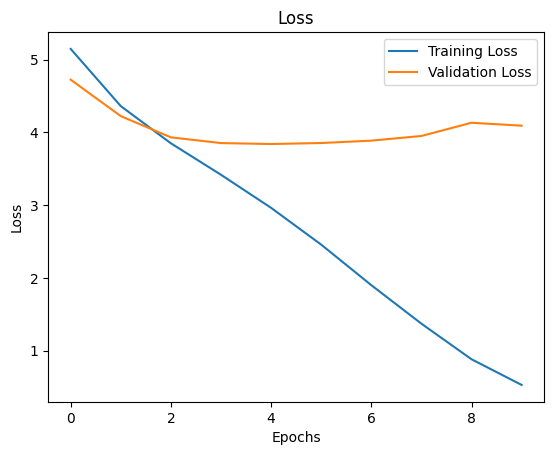

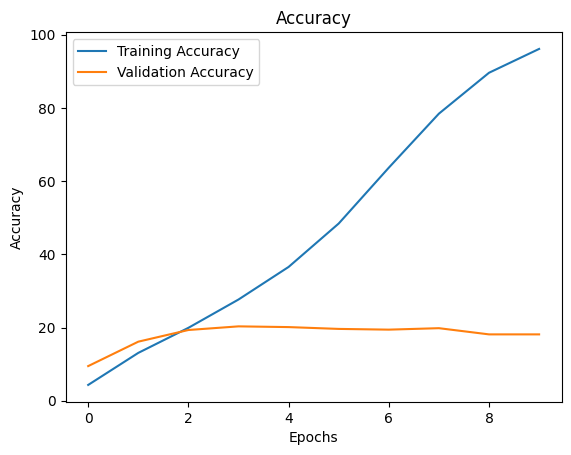

In [21]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)

In [23]:
val = ImageDataset(datasets.VALIDATION_LABELED_20,224,True)
val = DataLoader(val,batch_size=1,shuffle=False)
from utils.fine_tune_pytorch import eval_model_on_test_loader
model.load_state_dict(torch.load(best_model_path))

cm = eval_model_on_test_loader(model, "Finetuned_FOOD101_ResNet50_labelspread_validation", "self-supervised", val, True, 5)

100%|██████████| 1004/1004 [00:10<00:00, 94.76it/s]

Accuracy: 20.119521912350596 %
5-Accuracy: 43.72509960159363
